In [1]:
from stompy.spatial import proj_utils

import stompy.model.delft.dflow_model as dfm
import numpy as np
import logging
import pandas as pd
from matplotlib import dates

import xarray as xr
from stompy.grid import multi_ugrid
from stompy import utils, memoize, filters
import os
import six
import matplotlib.pyplot as plt
from matplotlib import colors

%matplotlib notebook

In [4]:
import run_database
six.moves.reload_module(run_database)
all_runs=run_database.all_runs

In [5]:
import common
from common import (prechain, his_cache, save_as_layers, load_or_none, name_runs,
                    scen_names, slr_names, events, label_events,
                   ebb_period,flood_period,ebb_time,spring_ebb_mid,
                   spring_flood_mid, spring_ebb, spring_flood)

DFM_ROOT NOT SET
local_config: LD_LIBRARY_PATH:
/share/apps/mpfr-3.1.2/lib:/share/apps/openmpi-4.1.4/gcc7/lib:/share/apps/ucx-1.13.1/gcc7/lib:/share/apps/pmix-4.1.1/gcc7/lib:/share/apps/hwloc-2.8.0/gcc7/lib:/share/apps/libevent-2.1.12-stable/gcc7/lib:/share/apps/slurm-22.05.4/18.04/lib
------------


In [6]:
runs=run_database.select(period='2016long',slr=0.00,flows='impaired',scen=3)

runs['model']=runs.run_dir.apply(lambda rd: dfm.DFlowModel.load(rd))


name_runs(runs)
runs

,run_dir,scen,layers,slr,period,status,terrain,flows,model,name
3,data_2016long_3d_asbuilt_impaired_scen3_l100-v...,3,100,0.0,2016long,complete,asbuilt,impaired,<DFlowModel: data_2016long_3d_asbuilt_impaired...,High


In [21]:
for _,run in runs.iterrows():
    his_ds=run['model'].his_dataset(chain=True,prechain=prechain)

    variables=['time','station_x_coordinate','station_y_coordinate',
               'stations', # 'station_id',
               'waterlevel','bedlevel', # 'taus',
               'depth-averaged_x_velocity','depth-averaged_y_velocity', 

               'cross_section',
               'cross_section_name','cross_section_discharge','cross_section_area',
               'cross_section_velocity'
               ]
    # all named stations
    #stations=['pch_up','pch_down','lag1','nmc_down','BC3','ch2','bc1',
    #          'nck','bbr','bbrch','pc3','nmp','nmc_up','mid_mouth','mouth_thalweg',
    #          'npc']

    # relevant to North Marsh design proposal
    stations=['pch_up','pch_down','lag1','nmc_down',
              'nck','pc3','nmp','nmc_up','npc','thalweg_pesc_0045']
    ds=his_ds.copy() # shallow

    for v in list(ds):
        if v not in variables:
            del ds[v]
    for v in list(ds.coords):
        dims=ds[v].dims
        if v=='time': continue
        if ('laydim' in dims) or ('laydimw' in dims):
            del ds[v]
            continue
        if 'stations' in dims: continue
        if 'cross_section' in dims: continue
        del ds[v]

    del ds['cross_section_name']
    del ds['station_name']

    ds_sel=ds.sel(stations=stations)
    ds_sel.attrs['projection']='EPSG:26910'
    ds_sel.attrs['model_run']=run['run_dir']
    export_dir='export'
    if not os.path.exists(export_dir):
        os.makedirs(export_dir)
    nc_fn=os.path.join(export_dir,f'{run["name"]}.nc')
    print("Compute")
    ds_sel_c=ds_sel.compute()
    print(f"Writing to {nc_fn}")
    ds_sel_c.to_netcdf(nc_fn)

2 chained datasets
Geometries match?
Compute
Writing to export/High.nc


In [7]:
ls -lh export

total 47M
-rw-rw-r-- 1 rustyh rustyh 26M Oct 18 19:43 Base.nc
-rw-rw-r-- 1 rustyh rustyh 21M Jan 17 15:24 High.nc
-rw-rw-r-- 1 rustyh rustyh 24M Oct 18 19:59 Low.nc
-rw-rw-r-- 1 rustyh rustyh 24M Oct 18 20:18 Medium.nc


In [8]:
# 2023-01-17:
#  Also include output for a point in Pescadero Ck near the Pescadero Channel

his_ds=runs['model'].values[0].his_dataset(chain=False,prechain=prechain)

In [10]:
map_ds=runs['model'].values[0].map_dataset(chain=False)

INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Removing orphaned nodes
INFO:UnstructuredGrid:0 nodes found to be orphans
INFO:UnstructuredGrid:Removing duplicate nodes
INFO:UnstructuredGrid:Renumbering nodes
INFO:UnstructuredGrid:Renumbering edges
INFO:UnstructuredGrid:Extracting grid boundary
INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Removing orphaned nodes
INFO:UnstructuredGrid:0 nodes found to be orphans
INFO:UnstructuredGrid:Removing duplicate nodes
INFO:UnstructuredGrid:Renumbering nodes
INFO:UnstructuredGrid:Renumbering edges
INFO:UnstructuredGrid:Extracting grid boundary
INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Removing orphaned nodes
INFO:UnstructuredGrid:0 nodes found to be orphans
INFO:UnstructuredGrid:Removing duplicate nodes
INFO:UnstructuredGrid:Renumbering nodes
INFO:UnstructuredGrid:Renumbering edges
INFO:UnstructuredGrid:Extracting grid boundary
INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Remo

INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)


<IPython.core.display.Javascript object>


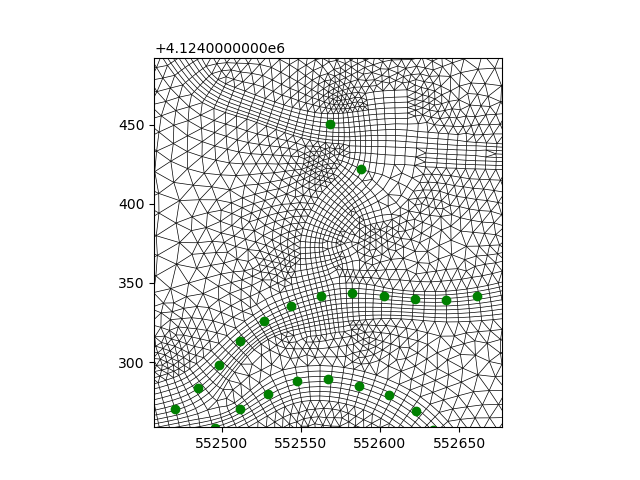

In [14]:
fig,ax=plt.subplots()
map_ds.grid.plot_edges(ax=ax,color='k',lw=0.5)

ax.plot(his_ds.station_x_coordinate, his_ds.station_y_coordinate,'go')

In [20]:
if 0:
    # Get a name for a station close to the Pescadero Channel/Creek junction
    pescadero_jct=[552563.492,4124341.237]
    stn_xy = np.c_[ his_ds.station_x_coordinate.values, his_ds.station_y_coordinate.values]
    dists=utils.dist( pescadero_jct, stn_xy)
    stn_idx=np.argmin(dists)
    stn_idx
    his_ds.stations.isel(stations=stn_idx) # 'thalweg_pesc_0045'
    dists[stn_idx]

In [9]:
# Read in the output and write some more usable csvs.
import xarray as xr
ds=xr.open_dataset("export/High.nc")

In [78]:
# For starters there are 16 cross sections and 10 stations.

ds_sel=ds.sel(stations=['nck','pc3','npc','thalweg_pesc_0045'],
              cross_section=['n_complex_xs','pesca_mid_xs','pesca_rndhill','pesca_top_xs'])

# Get utm coordinates for the cross sections:
def cross_section_xy(name):
    geom=his_ds.cross_section_geom.sel(cross_section=name).item()
    return np.r_[geom.centroid.x,geom.centroid.y]
points=np.array( [cross_section_xy(name) for name in ds_sel.cross_section.values])
ds_sel['cross_section_x_coordinate']=('cross_section',),points[:,0]
ds_sel['cross_section_y_coordinate']=('cross_section',),points[:,1]

# Get lat/long for stations and sections:
stn_xy=np.c_[ ds_sel.station_x_coordinate.values, ds_sel.station_y_coordinate.values]
stn_ll=proj_utils.mapper('EPSG:26910','WGS84')(stn_xy)
crs_xy=np.c_[ ds_sel.cross_section_x_coordinate.values, 
              ds_sel.cross_section_y_coordinate.values] 
crs_ll=proj_utils.mapper('EPSG:26910','WGS84')(crs_xy)

ds_sel['station_longitude']=('stations',), stn_ll[:,0]
ds_sel['station_latitude']=('stations',), stn_ll[:,1]
ds_sel['cross_section_longitude']=('cross_section',),crs_ll[:,0]
ds_sel['cross_section_latitude']=('cross_section',),crs_ll[:,1]

ds_sel=ds_sel.reset_coords()

In [79]:
# Write a CSV with location information:
crs_locs = ( ds_sel[ ['cross_section','cross_section_latitude','cross_section_longitude']]
  .rename({'cross_section':'name',
           'cross_section_latitude':'latitude',
           'cross_section_longitude':'longitude'})
)

stn_locs = ( ds_sel[ ['stations','station_latitude','station_longitude']]
           .rename({'stations':'name',
                    'station_latitude':'latitude',
                    'station_longitude':'longitude'}))
crs_df=crs_locs.to_dataframe()
stn_df=stn_locs.to_dataframe()

crs_df['type']='cross_section'
stn_df['type']='station'

loc_df = pd.concat( [stn_df,crs_df])
loc_df.to_csv("export/High-locations.csv")

In [89]:
# Get a downstream-directed velocity for the stations:
# Well, depth-averaged output is broken. Omit station velocity, see if
# they really need it.
if 0:
    u_princ=np.zeros( (ds_sel.dims['stations'],ds_sel.dims['time']))

    for stn_i in range(ds_sel.dims['stations']):
        u=ds_sel['depth-averaged_x_velocity'].isel(stations=stn_i).values
        v=ds_sel['depth-averaged_y_velocity'].isel(stations=stn_i).values
        eta=ds_sel['waterlevel'].isel(stations=stn_i).values
        U=utils.rotate_to_principal(np.c_[u,v], eta=eta, positive='ebb')
        u_princ[stn_i,:]=U[:,0]
    ds_sel['velocity']=('stations','time'),u_princ
    
ds_stations=ds_sel[ ['waterlevel'] ].reset_coords().rename({'waterlevel':'waterlevel_m'})
stations_df = ds_stations.to_dataframe().unstack(0) # put stations as columns

In [91]:
ds_sel['velocity_ms']=ds_sel['cross_section_discharge'] / ds_sel['cross_section_area'].clip(0.001)

ds_sections=( ds_sel[ ['cross_section_discharge','velocity']]
             .rename({'cross_section_discharge':'flow_cms'})
             .reset_coords())
sections_df=ds_sections.to_dataframe().unstack(0)

In [92]:
df_complete=pd.concat( [stations_df, sections_df],axis=1)

In [93]:
df_complete.to_csv('export/High.csv')

In [72]:
ds_sections

<xarray.Dataset>
Dimensions:        (cross_section: 3, time: 23233)
Coordinates:
  * time           (time) datetime64[ns] 2016-07-01 ... 2017-02-28
  * cross_section  (cross_section) object 'n_complex_xs' ... 'pesca_rndhill'
Data variables:
    flow           (time, cross_section) float64 0.0 0.0 0.0 ... 0.0 6.276 6.145
    velocity       (time, cross_section) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
Attributes:
    institution:    Deltares
    references:     http://www.deltares.nl
    source:         Deltares, D-Flow FM Version 1.2.143.141115M, May 17 2022,...
    history:        Created on 2022-07-20T05:11:43-0700, D-Flow FM
    date_created:   2022-07-20T05:11:43-0700
    date_modified:  2022-07-20T05:11:43-0700
    Conventions:    CF-1.5 Deltares-0.1
    projection:     EPSG:26910
    model_run:      data_2016long_3d_asbuilt_impaired_scen3_l100-v010_r00

<IPython.core.display.Javascript object>


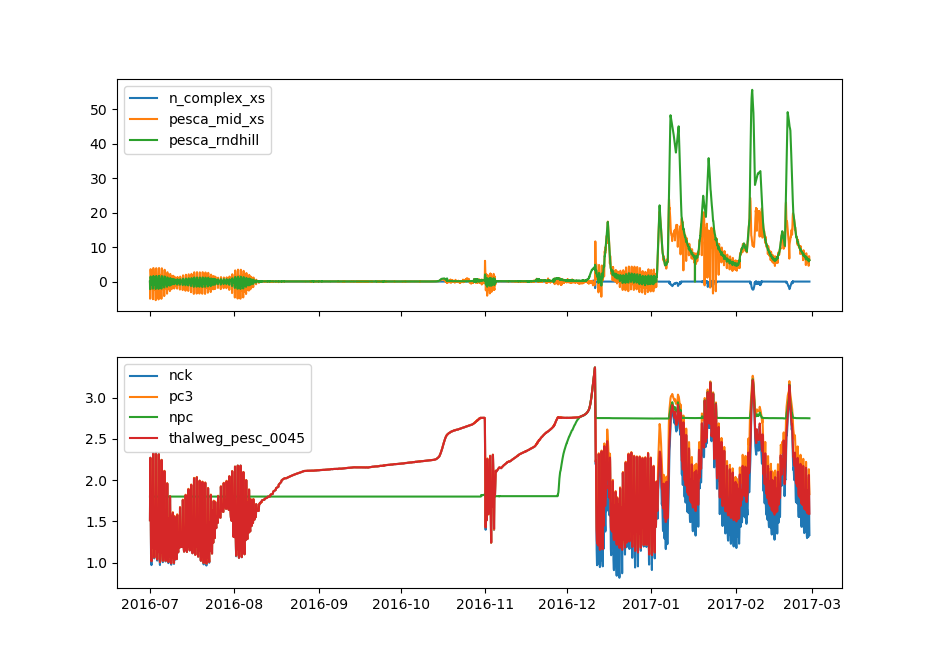

In [77]:
fig,axs=plt.subplots(2,1,sharex=True)

for name in ds_sections['cross_section'].values:
    axs[0].plot( ds_sections.time, ds_sections['flow'].sel(cross_section=name), label=name)
axs[0].legend()

for name in ds_stations['stations'].values:
    axs[1].plot( ds_stations.time, ds_stations['waterlevel'].sel(stations=name), label=name)
axs[1].legend()


In [88]:
ds_sel.cross_section_area.

<xarray.DataArray 'cross_section_area' (time: 23233, cross_section: 4)>
array([[ 0.      , 16.575014, 15.454034,  1.11543 ],
       [ 0.      , 18.82388 , 15.976626,  1.11624 ],
       [ 0.      , 21.188573, 17.305841,  1.675711],
       ...,
       [ 0.      , 19.004764, 21.9636  , 11.682086],
       [ 0.      , 18.805312, 21.861318, 11.659041],
       [ 0.      , 18.646775, 21.765368, 11.628235]])
Coordinates:
  * cross_section  (cross_section) object 'n_complex_xs' ... 'pesca_top_xs'
  * time           (time) datetime64[ns] 2016-07-01 ... 2017-02-28
Attributes:
    units:     m2
    geometry:  cross_section_geom